In [1]:
pip install recommenders==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.6/335.6 KB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 KB 16.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 KB 25.0 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.1
    Uninstalling Jinj

In [2]:
conda install cornac -c conda-forge

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cornac


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cornac-1.14.2              |   py37h696cff9_0         3.0 MB  conda-forge
    mpmath-1.2.1               |     pyhd8ed1ab_0         437 KB  conda-forge
    powerlaw-1.4.6             |     pyh9f0ad1d_1          29 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  cornac             conda-forge/linux-64::cornac-1.14.2-py37h696cff9_0
  mpmath             conda-forge/noarch::mpmath-1.2.1-pyhd8ed1ab_0
  powerlaw           conda-forge/noarch::powerlaw-1.4.6-pyh9f0ad1d_1



powerlaw-1.4.6       | 29 KB     | ##################################### | 100% 
cornac-1.14.2        | 3.0 MB

In [3]:
import sys
import os
import cornac
import numpy as np
import pandas as pd
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

print("System version: {}".format(sys.version))
print("Cornac version: {}".format(cornac.__version__))

System version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Cornac version: 1.14.2


In [4]:
import time
import logging
import multiprocessing as mp

In [5]:
# top k items to recommend
TOP_K = 12

# Model parameters
NUM_FACTORS = 200
NUM_EPOCHS = 100

In [6]:
data_path = r'../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
customer_data_path = r'../input/h-and-m-personalized-fashion-recommendations/customers.csv'
article_data_path = r'../input/h-and-m-personalized-fashion-recommendations/articles.csv'
submission_data_path = r'../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [7]:
# Data Extraction
def create_data(datapath, data_type=None):
    if data_type is None:
        df = pd.read_csv(datapath)
    elif data_type == 'transaction':
        df = pd.read_csv(datapath, dtype={'article_id': str}, parse_dates=['t_dat'])
    elif data_type == 'article':
        df = pd.read_csv(datapath, dtype={'article_id': str})
    return df

In [8]:
%%time

# Load all sales data (for 3 years starting from 2018 to 2020)
# ALso, article_id is treated as a string column otherwise it 
# would drop the leading zeros while reading the specific column values
transactions_data=create_data(data_path, data_type='transaction')
print(transactions_data.shape)

# # Unique Attributes
print(str(len(transactions_data['t_dat'].drop_duplicates())) + "-total No of unique transactions dates in data sheet")
print(str(len(transactions_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in data sheet")
print(str(len(transactions_data['article_id'].drop_duplicates())) + "-total No of unique article ids courses names in data sheet")
print(str(len(transactions_data['sales_channel_id'].drop_duplicates())) + "-total No of unique sales channels in data sheet")

(31788324, 5)
734-total No of unique transactions dates in data sheet
1362281-total No of unique customers ids in data sheet
104547-total No of unique article ids courses names in data sheet
2-total No of unique sales channels in data sheet
CPU times: user 1min 18s, sys: 3.56 s, total: 1min 21s
Wall time: 1min 49s


In [9]:
%%time

# Load all Customers
customer_data=create_data(customer_data_path)
print(customer_data.shape)

print(str(len(customer_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in customer data sheet")

(1371980, 7)
1371980-total No of unique customers ids in customer data sheet
CPU times: user 4.79 s, sys: 227 ms, total: 5.02 s
Wall time: 6.85 s


In [10]:
%%time

# Load all Customers
article_data=create_data(article_data_path, data_type='article')
print(article_data.shape)

print(str(len(article_data['article_id'].drop_duplicates())) + "-total No of unique article ids in article data sheet")

(105542, 25)
105542-total No of unique article ids in article data sheet
CPU times: user 901 ms, sys: 30.8 ms, total: 932 ms
Wall time: 1.26 s


In [11]:
transactions_data = transactions_data[transactions_data['t_dat'] > '2020-08-21']
transactions_data.shape

(1190911, 5)

In [12]:
transactions_data = transactions_data.groupby(['customer_id','article_id']).agg({'t_dat':'count'}).reset_index()
transactions_data = transactions_data[['customer_id','article_id','t_dat']]

In [13]:
transactions_data.head()

,customer_id,article_id,t_dat
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,1
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,1
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0448509014,1
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003,1
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0516859008,1


In [14]:
def get_customers_list():
    return np.sort(transactions_data['customer_id'].unique())

def get_articles_list():
    return np.sort(transactions_data['article_id'].unique())

def id_mappings(customers_list, articles_list):
    """
    
    Create id mappings to convert user_id and item_id
    
    """
    customer_to_index_mapping = {}
    index_to_customer_mapping = {}
    for customer_index, customer_id in enumerate(customers_list):
        customer_to_index_mapping[customer_id] = customer_index
        index_to_customer_mapping[customer_index] = customer_id
        
    article_to_index_mapping = {}
    index_to_article_mapping = {}
    for article_index, article_id in enumerate(articles_list):
        article_to_index_mapping[article_id] = article_index
        index_to_article_mapping[article_index] = article_id
        
    return customer_to_index_mapping, index_to_customer_mapping, \
           article_to_index_mapping, index_to_article_mapping

In [15]:
customers = get_customers_list()
articles = get_articles_list()

In [16]:
# Generate mapping, LightFM library can't read other than (integer) index
customer_to_index_mapping, index_to_customer_mapping, \
article_to_index_mapping, index_to_article_mapping = id_mappings(customers, articles)

In [17]:
transactions_data['userID'] = transactions_data['customer_id'].apply(lambda x:customer_to_index_mapping.get(x))
transactions_data['itemID'] = transactions_data['article_id'].apply(lambda x:article_to_index_mapping.get(x))
transactions_data = transactions_data[['userID','itemID','t_dat']].rename(columns={'t_dat':'rating'})

In [18]:
train, test = python_random_split(transactions_data, 0.75)

In [19]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of customers: {}'.format(train_set.num_users))
print('Number of articles: {}'.format(train_set.num_items))

Number of customers: 237125
Number of articles: 27853


In [20]:
bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED
)

In [21]:
with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Took 63.0131 seconds for training.


In [22]:
logger    = mp.get_logger()
formatter = logging.Formatter('[%(levelname)s/%(processName)s/%(asctime)s] %(message)s')
handler   = logging.StreamHandler()
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [23]:
train

,userID,itemID,rating
185275,45014,3667,1
160734,38971,7587,1
568624,138428,4900,3
666221,162016,29081,1
1024224,249507,21595,1
...,...,...,...
110268,26720,26894,1
259178,63051,23372,1
131932,31942,13781,1
671155,163217,21426,1


In [24]:
def prediction_v1(
    model,
    data,
    bpr_train_set_map_items,
    buffer,
    usercol='userID',
    itemcol='itemID',
    predcol='prediction',
):
    """Computes predictions of recommender model from Cornac on all users and items in data.
    It can be used for computing ranking metrics like NDCG.
    Args:
        model (cornac.models.Recommender): a recommender model from Cornac
        data (pd.DataFrame): the data from which to get the users and items
        usercol (str): name of the user column
        itemcol (str): name of the item column
        remove_seen (bool): flag to remove (user, item) pairs seen in the training data
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """
    try:
        predictions_items_users = []
        data_already_seen       = frozenset(map(tuple, data[[usercol, itemcol]].to_numpy()))
        item                    = list(model.train_set.iid_map.keys())
        for uid, user_idx in bpr_train_set_map_items:
            user        = [uid] * len(item)
            predictions = model.score(user_idx).tolist()
            
            user_predictions = [(pred, itm, usr) for pred, itm, usr in zip(predictions, item, user) if(usr, itm) not in data_already_seen]
            user_predictions = sorted(user_predictions, reverse=True)[:TOP_K]
            predictions_items_users.extend(user_predictions)
            
        unseen_predictions = pd.DataFrame(
            data    = predictions_items_users,
            columns = [predcol, itemcol, usercol]
        ).sort_values([usercol, predcol], ascending=[True, False], inplace=False, ignore_index=True)[[usercol, itemcol, predcol]] # de sters pt prod version

        if unseen_predictions.empty == False:
            buffer.put(unseen_predictions)

    except Exception as e:
        logger.error(f'Error at prediction: {e}')

def process_based_multitasking(function_call: object, function_args: dict, cores: int = mp.cpu_count())-> pd.DataFrame:
    '''This should devide "bpr.train_set.uid_map.items()" and creates a number of "cores" processes who occupies
     one core each and call one time the "function_call" function with it's respective arguments.'''
    try:
        model   = function_args.get('model')
        data    = function_args.get('data')
        usercol = function_args.get('usercol')
        itemcol = function_args.get('itemcol')
        predcol = function_args.get('predcol')
        bpr_train_set_map_items = function_args.get('bpr_train_set_map_items')

        train_items_batch = len(bpr_train_set_map_items) // cores
        scrapes           = len(bpr_train_set_map_items) % cores
        scrapes_list      = [0] * (cores - scrapes) + [1] * scrapes

        response_list = []
        with mp.Manager() as manager:
            buffer = manager.Queue()
            with mp.Pool(cores) as process_pool:

                # Branchless slicing data per core masterrace
                for index in range(cores):
                    slice_start = index * train_items_batch + sum(scrapes_list[:index])
                    slice_end   = (index + 1) * train_items_batch + sum(scrapes_list[:index]) + 1 * scrapes_list[index] + ((index == (cores - 1))) #* (-(len(bpr_train_set_map_items) + 1)))
                    sample_bpr_train_set = bpr_train_set_map_items[slice_start: slice_end]
                    response_list.append(process_pool.apply_async(function_call, (model, data, sample_bpr_train_set, buffer, usercol, itemcol, predcol, )))

                process_pool.close()
                process_pool.join()

            buffer.put(None)
            df_buffer = pd.DataFrame(columns=[usercol, itemcol, predcol])
            while True:
                item = buffer.get()
                if item is None:
                    break
                else:
                    df_buffer = pd.concat([df_buffer, item], ignore_index=True)

        return df_buffer.sort_values([usercol, predcol], ascending=[True, False], inplace=False, ignore_index=True)
    except Exception as e:
        logger.error(e)

In [25]:
function_args = {'model':  bpr, 
                'data':    train, 
                'usercol': 'userID', 
                'itemcol': 'itemID', 
                'predcol': 'prediction', 
                'bpr_train_set_map_items': tuple(bpr.train_set.uid_map.items())
                }

model   = function_args.get('model')
data    = function_args.get('data')
usercol = function_args.get('usercol')
itemcol = function_args.get('itemcol')
predcol = function_args.get('predcol')
bpr_train_set_map_items = function_args.get('bpr_train_set_map_items')
cores   = mp.cpu_count()

In [26]:
start = time.time()
predictions_df = process_based_multitasking(prediction_v1, function_args, cores)
end = time.time()

print(predictions_df)
print(f'It took process_based_multitasking prediction_v1: {(end-start)} seconds.')

[INFO/SyncManager-1/2022-04-20 16:44:13,025] child process calling self.run()
[INFO/SyncManager-1/2022-04-20 16:44:13,029] created temp directory /tmp/pymp-1pcdmgcy
[INFO/SyncManager-1/2022-04-20 16:44:13,032] manager serving at '/tmp/pymp-1pcdmgcy/listener-5q070djh'
[INFO/ForkPoolWorker-2/2022-04-20 16:44:13,058] child process calling self.run()
[INFO/ForkPoolWorker-3/2022-04-20 16:44:13,072] child process calling self.run()
[INFO/ForkPoolWorker-4/2022-04-20 16:44:13,087] child process calling self.run()
[INFO/ForkPoolWorker-5/2022-04-20 16:44:13,103] child process calling self.run()
[INFO/ForkPoolWorker-5/2022-04-20 19:33:14,986] process shutting down
[INFO/ForkPoolWorker-4/2022-04-20 19:33:14,986] process shutting down
[INFO/ForkPoolWorker-2/2022-04-20 19:33:14,987] process shutting down
[INFO/ForkPoolWorker-3/2022-04-20 19:33:14,990] process shutting down
[INFO/ForkPoolWorker-4/2022-04-20 19:33:14,994] process exiting with exitcode 0
[INFO/ForkPoolWorker-2/2022-04-20 19:33:14,995] 

         userID itemID  prediction
0             1  28123    5.017048
1             1   8607    5.012327
2             1  28330    4.893550
3             1  28120    4.862915
4             1   5928    4.836989
...         ...    ...         ...
2845495  256354    683    4.714649
2845496  256354  28353    4.711578
2845497  256354  27521    4.707643
2845498  256354  28751    4.706281
2845499  256354   6426    4.702415

[2845500 rows x 3 columns]
It took process_based_multitasking prediction_v1: 10145.575517892838 seconds.


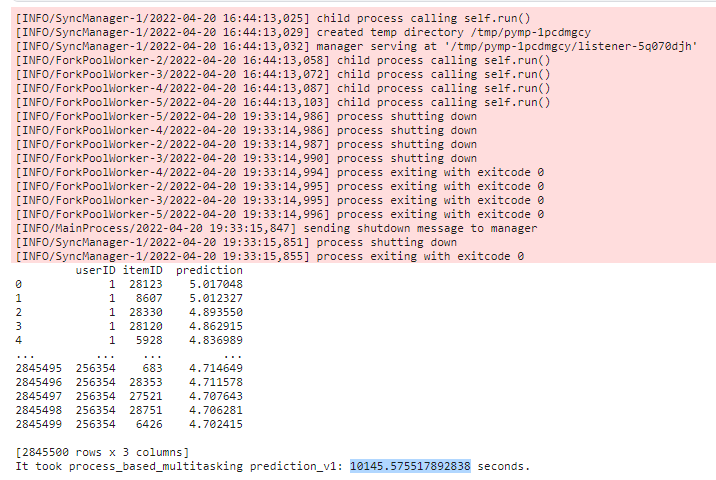

In [27]:
predictions_df

,userID,itemID,prediction
0,1,28123,5.017048
1,1,8607,5.012327
2,1,28330,4.893550
3,1,28120,4.862915
4,1,5928,4.836989
...,...,...,...
2845495,256354,683,4.714649
2845496,256354,28353,4.711578
2845497,256354,27521,4.707643
2845498,256354,28751,4.706281


In [28]:
predictions_df['userID'] = predictions_df['userID'].astype(int)
predictions_df['itemID'] = predictions_df['itemID'].astype(int)
predictions_df['prediction'] = predictions_df['prediction'].astype(float)
test['rating'] = test['rating'].astype(float)

In [29]:
k = 12
eval_map = map_at_k(test, predictions_df, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, predictions_df, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, predictions_df, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, predictions_df, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.006780
NDCG:	0.011924
Precision@K:	0.003329
Recall@K:	0.022483


In [30]:
predictions_df.to_parquet('all_predictions.parquet')